In [49]:
! pip install -U scikit-learn
! pip install matplotlib
! pip install pandas
! pip install numpy
! pip install scikit-plot
! pip install scipy==1.11.4
! pip install seaborn

In [ ]:
import pickle
import random
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
import pandas as pd

In [55]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
pkl_path = '/Users/shreyanakum/Documents/CS178/CS-178-Project/DATA/tfidf_data.pkl'
classes = ['toxic', 'severe_toxic', 'insult', 'threat', 'obscene', 'identity_hate']
alpha = 1.0
max_iters = 50
convergence_tol = 1e-5
seed = 42
random.seed(seed)
np.random.seed(seed)

# Load Data

In [ ]:
with open(pkl_path, 'rb') as f:
    tfidf_data = pickle.load(f)

X_train = tfidf_data['X_train'] # scipy sparse
X_test = tfidf_data['X_test']
y_train_raw = tfidf_data['y_train']
y_test = tfidf_data['y_test']
vectorizer = tfidf_data['vectorizer']

# Ensure CSR = https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.tocsr.html
X = X_train.tocsr() if hasattr(X_train, 'tocsr') else csr_matrix(X_train)
n_docs, vocab_size = X.shape
C = len(classes)
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

## normalization of labels to integer indices
# convert into np array

if isinstance(y_train_raw, (pd.Series, pd.DataFrame)):
    y_arr = y_train_raw.values
else:
    y_arr = np.array(y_train_raw)

if y_arr.ndim == 2:
    # assume rows are multi-label or one-hot; pick first positive class if any
    y_idx = []
    for row in y_arr:
        row = np.asarray(row)
        pos = np.where(row > 0)[0]
        if len(pos) > 0:
            first_pos = int(pos[0])
            # map column index to class index if needed; here we assume same ordering
            y_idx.append(first_pos if first_pos < C else 0)
        else:
            # no positive, default to class 0
            y_idx.append(0)
    y_idx = np.array(y_idx, dtype=int)
else:
    # 1D labels; assume each entry is a class name or something mappable
    y_idx = []
    for lbl in y_arr:
        lbl_str = str(lbl)
        if lbl_str in class_to_idx:
            y_idx.append(class_to_idx[lbl_str])
        else:
            # if label not in predefined classes, default to 0
            y_idx.append(0)
    y_idx = np.array(y_idx, dtype=int)

# Training

In [ ]:
# step 1: Hide 10% per class
mask_labeled = np.ones(n_docs, dtype=bool)
for c_name, c in class_to_idx.items():
    inds = np.where(y_idx == c)[0]
    if len(inds) == 0:
        continue
    k = max(1, int(0.10 * len(inds)))
    hide = np.random.choice(inds, size=k, replace=False)
    mask_labeled[hide] = False

L_inds = np.where(mask_labeled)[0]
U_inds = np.where(~mask_labeled)[0]

# init responsibilities q
q = np.zeros((n_docs, C), dtype=float)
q[L_inds, :] = 0.0
q[U_inds, :] = 1.0 / C
for i in L_inds:
    q[i, y_idx[i]] = 1.0

def supervised_nb_init(X, y_idx, L_inds, alpha=1.0):
    V = X.shape[1]
    counts = Counter(y_idx[L_inds])
    total = len(L_inds)
    pi = np.array([(counts.get(c, 0) + 1.0) / (total + C) for c in range(C)])
    word_counts = np.zeros((C, V), dtype=float)
    for i in L_inds:
        row = X.getrow(i)
        if row.nnz == 0: 
            continue
        cols = row.indices
        vals = row.data
        word_counts[y_idx[i], cols] += vals
    wc_sums = word_counts.sum(axis=1) + alpha * V
    theta = (word_counts + alpha) / wc_sums[:, None]
    return pi, theta

def e_step_logprobs(X, pi, theta):
    N, V = X.shape
    C = len(pi)
    log_pi = np.log(pi)
    log_theta = np.log(theta)
    q_new = np.zeros((N, C), dtype=float)
    for i in range(N):
        row = X.getrow(i)
        if row.nnz == 0:
            # fallback proportional to priors
            scores = log_pi.copy()
        else:
            cols = row.indices
            vals = row.data
            scores = log_pi + (log_theta[:, cols] * vals).sum(axis=1)
        m = np.max(scores)
        probs = np.exp(scores - m)
        q_new[i] = probs / probs.sum()
    return q_new

def m_step_nb(X, q, alpha=1.0):
    N, V = X.shape
    C = q.shape[1]
    # priors with add-1 smoothing
    class_mass = q.sum(axis=0)
    pi = (class_mass + 1.0) / (class_mass.sum() + C)
    # fractional word counts
    word_counts = np.zeros((C, V), dtype=float)
    for i in range(N):
        row = X.getrow(i)
        if row.nnz == 0:
            continue
        cols = row.indices
        vals = row.data
        qi = q[i]
        for c in range(C):
            if qi[c] == 0.0:
                continue
            word_counts[c, cols] += qi[c] * vals
    wc_sums = word_counts.sum(axis=1) + alpha * V
    theta = (word_counts + alpha) / wc_sums[:, None]
    return pi, theta

def expected_complete_LL(X, pi, theta, q):
    N, V = X.shape
    log_pi = np.log(pi)
    log_theta = np.log(theta)
    L = 0.0
    for i in range(N):
        row = X.getrow(i)
        cols = row.indices
        vals = row.data
        for c in range(C):
            if q[i, c] == 0.0:
                continue
            s = log_pi[c]
            if row.nnz:
                s += (log_theta[c, cols] * vals).sum()
            L += q[i, c] * s
    return float(L)

# init params and pi from labeled data
pi, theta = supervised_nb_init(X, y_idx, L_inds, alpha)

# EM loop
prev_L = -1e18
for it in range(1, max_iters + 1):
    # E-step
    q_new = e_step_logprobs(X, pi, theta)
    # clamp labeled examples to hard assignments
    q_new[L_inds, :] = 0.0
    for i in L_inds:
        q_new[i, y_idx[i]] = 1.0

    # M-step
    pi_new, theta_new = m_step_nb(X, q_new, alpha)

    # convergence check using expected complete-data log-likelihood
    L = expected_complete_LL(X, pi_new, theta_new, q_new)
    rel_change = (L - prev_L) / (abs(prev_L) + 1e-12)
    print(f'iter={it}  L={L:.6f}  rel_change={rel_change:.6e}')

    q, pi, theta = q_new, pi_new, theta_new
    if abs(rel_change) < convergence_tol:
        print('Converged.')
        break
    prev_L = L

# final priors and a quick labeled-subset accuracy for sanity
print(pd.Series(pi, index=classes, name='class_prior_pi').to_csv())
train_scores = e_step_logprobs(X, pi, theta)
train_pred = train_scores.argmax(axis=1)
labeled_acc = (train_pred[L_inds] == y_idx[L_inds]).mean() if len(L_inds) else float('nan')
print(pd.DataFrame({'metric': ['train_acc_on_labeled_subset'], 'value': [labeled_acc]}).to_csv(index=False))

iter=1  L=-5696367.751881  rel_change=1.000000e+00
iter=2  L=-5696360.100742  rel_change=1.343161e-06
Converged.
,class_prior_pi
toxic,0.9945253405042593
severe_toxic,7.911756307422128e-06
insult,0.0031148645115947073
threat,0.0001823353419682206
obscene,0.0018438293137124477
identity_hate,0.0003257185721579492

metric,value
train_acc_on_labeled_subset,0.994168436444661



# Testing

In [56]:
def nb_predict_proba(X_any, pi, theta):
    X_any = X_any.tocsr()
    N, V = X_any.shape
    C = len(pi)
    log_pi = np.log(pi)
    log_theta = np.log(theta)
    scores_all = np.zeros((N, C), dtype=float)
    for i in range(N):
        row = X_any.getrow(i)
        if row.nnz == 0:
            scores = log_pi.copy()
        else:
            cols = row.indices
            vals = row.data
            scores = log_pi + (log_theta[:, cols] * vals).sum(axis=1)
        scores_all[i] = scores
    # softmax to get probabilities
    m = np.max(scores_all, axis=1, keepdims=True)
    probs = np.exp(scores_all - m)
    probs /= probs.sum(axis=1, keepdims=True)
    return probs

def nb_predict(X_any, pi, theta):
    probs = nb_predict_proba(X_any, pi, theta)
    return probs.argmax(axis=1)

In [ ]:
X_test = tfidf_data['X_test']
y_test_raw = tfidf_data['y_test']

if isinstance(y_test_raw, (pd.Series, pd.DataFrame)):
    y_test_arr = y_test_raw.values
else:
    y_test_arr = np.array(y_test_raw)

# if test labels are in same multi-column one-hot form as train, mirror logic
if y_test_arr.ndim == 2:
    y_test_idx = []
    for row in y_test_arr:
        row = np.asarray(row)
        pos = np.where(row > 0)[0]
        if len(pos) > 0:
            first_pos = int(pos[0])
            y_test_idx.append(first_pos if first_pos < len(classes) else 0)
        else:
            y_test_idx.append(0)
    y_test_idx = np.array(y_test_idx, dtype=int)
else:
    y_test_idx = []
    for lbl in y_test_arr:
        lbl_str = str(lbl)
        if lbl_str in class_to_idx:
            y_test_idx.append(class_to_idx[lbl_str])
        else:
            y_test_idx.append(0)
    y_test_idx = np.array(y_test_idx, dtype=int)

In [58]:
y_test_pred_idx = nb_predict(X_test, pi, theta)
y_test_pred_labels = [classes[i] for i in y_test_pred_idx]
y_test_true_labels = [classes[i] for i in y_test_idx]

test_acc = accuracy_score(y_test_true_labels, y_test_pred_labels)
test_f1_weighted = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')

print(f"\nTest accuracy (EM NB): {test_acc}")
print(f"Weighted F1 (EM NB):   {test_f1_weighted}")


Test accuracy (EM NB): 0.9941093529688234
Weighted F1 (EM NB):   0.9911727300098004


In [ ]:
print("\nClassification report (EM NB):")
print(classification_report(y_test_true_labels, y_test_pred_labels, labels=classes, target_names=classes))


Classification report (EM NB):
               precision    recall  f1-score   support

        toxic       0.99      1.00      1.00     31727
 severe_toxic       0.00      0.00      0.00         0
       insult       0.00      0.00      0.00       101
       threat       0.00      0.00      0.00         1
      obscene       0.00      0.00      0.00        76
identity_hate       0.00      0.00      0.00        10

     accuracy                           0.99     31915
    macro avg       0.17      0.17      0.17     31915
 weighted avg       0.99      0.99      0.99     31915



/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to con

# Visualization (Confusion Matrix)


Confusion matrix (EM NB):
[[31727     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [  101     0     0     0     0     0]
 [    1     0     0     0     0     0]
 [   76     0     0     0     0     0]
 [   10     0     0     0     0     0]]


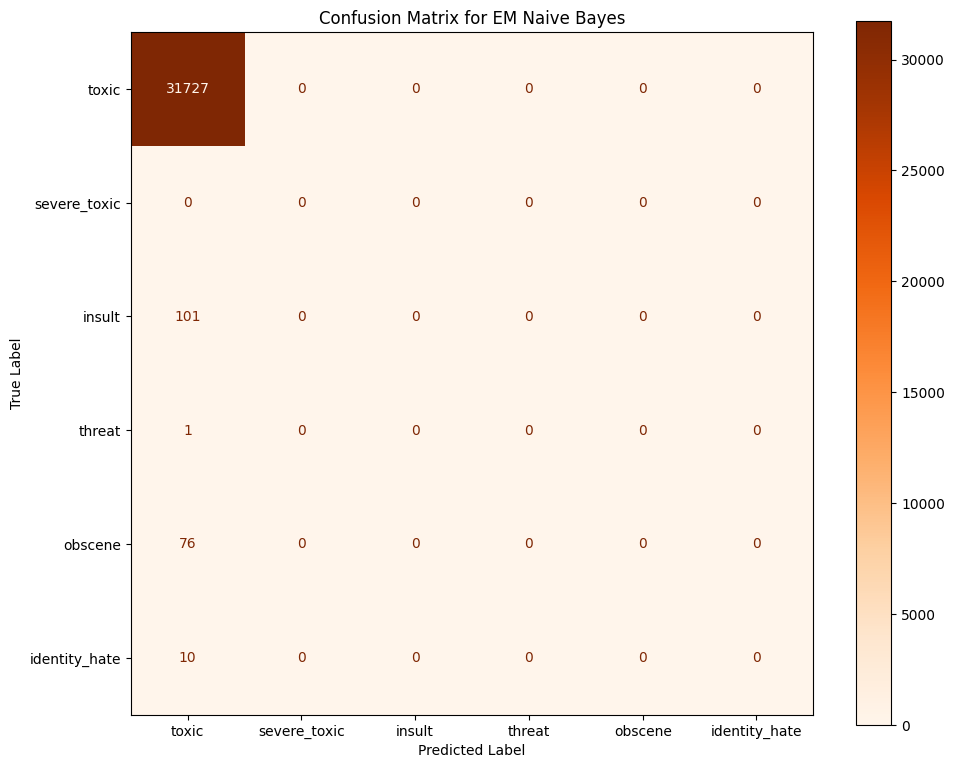

In [65]:
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels, labels=classes)
print("\nConfusion matrix (EM NB):")
print(cm)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap='Oranges', values_format='d')
plt.title('Confusion Matrix for EM Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()